## Chat myPDF : RAG with LLAMA, LangChain, Ollama, and FAISS Vector Store
### 1. Vector Stores and Retrievals

RAG PDF Dataset: https://github.com/laxmimerit/rag-dataset

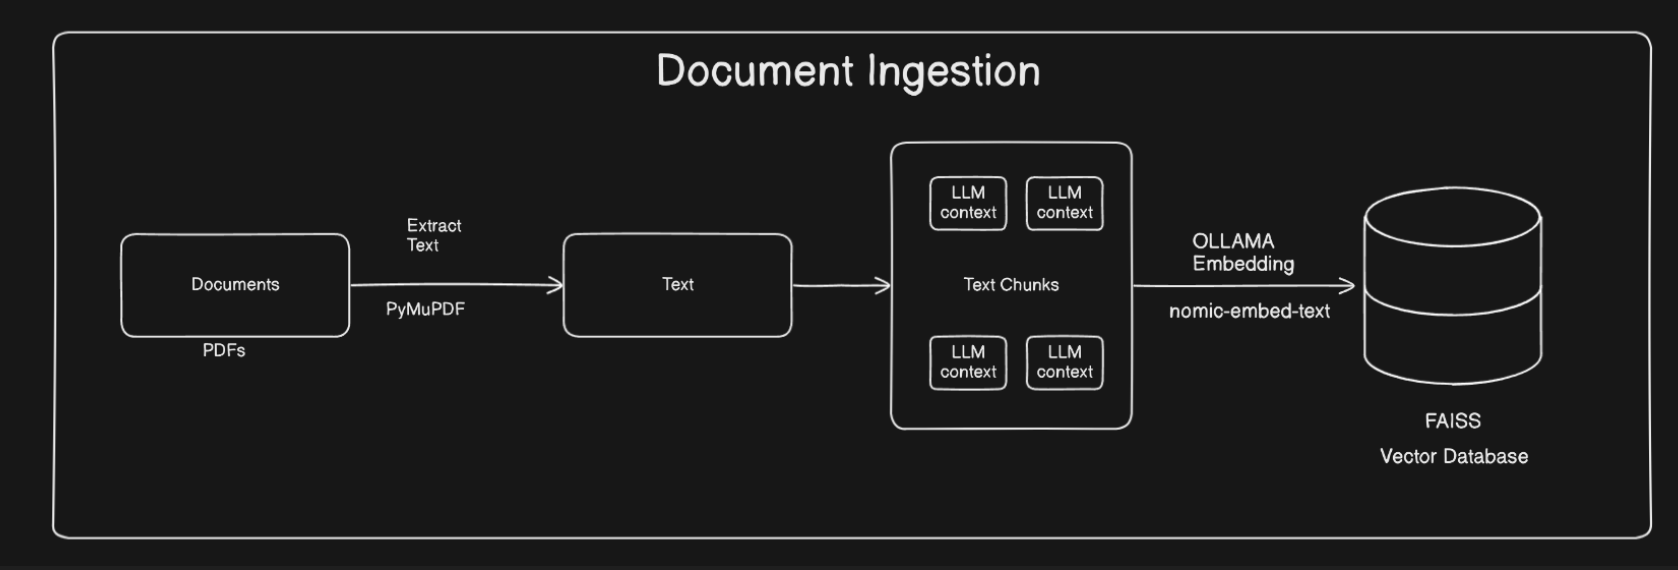

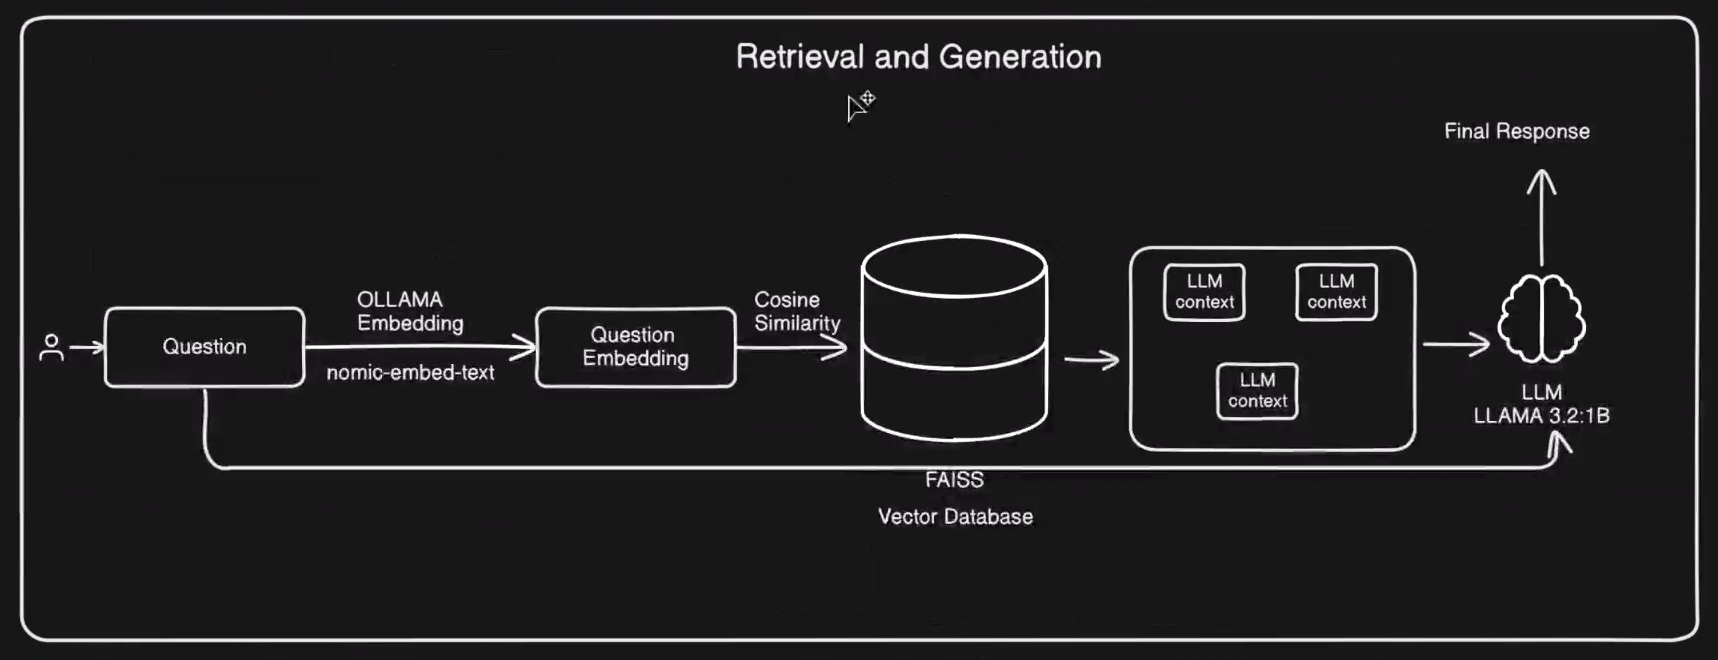

## [Vector stores - LangChain](https://python.langchain.com/docs/integrations/vectorstores/)

In [2]:
# !pip install faiss-cpu

In [3]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

True

## Data Loading

In [11]:
import os
from langchain.document_loaders import PyMuPDFLoader
from langchain.schema import Document
from typing import List
from pathlib import Path

In [14]:
def load_pdfs_from_directory(directory_path: str, verbose: bool = False) -> List[Document]:
    """
    Loads all PDF files from the specified directory and its subdirectories using LangChain's PyMuPDFLoader.

    Args:
        directory_path (str): Path to the directory containing PDF files or subdirectories.
        verbose (bool): If True, displays progress messages. Default is False.

    Returns:
        List[Document]: A list of Document objects with content and metadata extracted from the PDFs.

    Raises:
        FileNotFoundError: If the directory does not exist or is not accessible.
        ValueError: If the directory and its subdirectories do not contain any PDF files.
        Exception: For any unexpected issues during PDF loading.
    """
    if not os.path.exists(directory_path):
        raise FileNotFoundError(f"The directory '{directory_path}' does not exist.")

    if not os.path.isdir(directory_path):
        raise ValueError(f"The path '{directory_path}' is not a directory.")

    # Recursively find all PDF files in the directory and its subdirectories
    pdf_files = []
    for root, _, files in os.walk(directory_path):
        for file in files:
            if file.lower().endswith('.pdf'):
                pdf_files.append(os.path.join(root, file))

    if not pdf_files:
        raise ValueError(f"No PDF files found in the directory '{directory_path}' and its subdirectories.")

    if verbose:
        print(f"Found {len(pdf_files)} PDF file(s) in directory '{directory_path}' and its subdirectories.\n")

    documents = []
    for pdf_file in pdf_files:
        try:
            if verbose:
                print(f"Loading PDF: {pdf_file}...")
            loader = PyMuPDFLoader(pdf_file)
            documents.extend(loader.load())
            if verbose:
                print(f"Successfully loaded PDF: {pdf_file}\n")
        except Exception as e:
            print(f"Error loading PDF '{pdf_file}': {e}")

    if not documents:
        raise Exception("No documents were successfully loaded from the PDF files.")

    if verbose:
        print(f"\nLoaded {len(documents)} document(s) from the all the PDFs")

    return documents


In [15]:
docs = load_pdfs_from_directory(directory_path="./rag-dataset", verbose=True)

Found 5 PDF file(s) in directory './rag-dataset' and its subdirectories.

Loading PDF: ./rag-dataset\gym supplements\1. Analysis of Actual Fitness Supplement.pdf...
Successfully loaded PDF: ./rag-dataset\gym supplements\1. Analysis of Actual Fitness Supplement.pdf

Loading PDF: ./rag-dataset\gym supplements\2. High Prevalence of Supplement Intake.pdf...
Successfully loaded PDF: ./rag-dataset\gym supplements\2. High Prevalence of Supplement Intake.pdf

Loading PDF: ./rag-dataset\health supplements\1. dietary supplements - for whom.pdf...
Successfully loaded PDF: ./rag-dataset\health supplements\1. dietary supplements - for whom.pdf

Loading PDF: ./rag-dataset\health supplements\2. Nutraceuticals research.pdf...
Successfully loaded PDF: ./rag-dataset\health supplements\2. Nutraceuticals research.pdf

Loading PDF: ./rag-dataset\health supplements\3.health_supplements_side_effects.pdf...
Successfully loaded PDF: ./rag-dataset\health supplements\3.health_supplements_side_effects.pdf


Loade

## Document Chunking

In [16]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [17]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
chunks = text_splitter.split_documents(documents=docs)

In [19]:
len(chunks)

321

In [20]:
chunks[0]

Document(metadata={'source': './rag-dataset\\gym supplements\\1. Analysis of Actual Fitness Supplement.pdf', 'file_path': './rag-dataset\\gym supplements\\1. Analysis of Actual Fitness Supplement.pdf', 'page': 0, 'total_pages': 15, 'format': 'PDF 1.7', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'creator': '', 'producer': 'iLovePDF', 'creationDate': '', 'modDate': 'D:20241021113850Z', 'trapped': ''}, page_content='Citation: Espeño, P.R.; Ong, A.K.S.;\nGerman, J.D.; Gumasing, M.J.J.; Casas,\nE.S. Analysis of Actual Fitness\nSupplement Consumption among\nHealth and Fitness Enthusiasts. Foods\n2024, 13, 1424. https://doi.org/\n10.3390/foods13091424\nAcademic Editors: Ilija Djekic\nand Nada Smigic\nReceived: 30 March 2024\nRevised: 15 April 2024\nAccepted: 18 April 2024\nPublished: 6 May 2024\nCopyright: © 2024 by the authors.\nLicensee MDPI, Basel, Switzerland.\nThis article is an open access article\ndistributed\nunder\nthe\nterms\nand\nconditions of the Creative Commons\nA

In [18]:
import tiktoken

In [28]:
encoding = tiktoken.encoding_for_model("gpt-4o-mini")

In [37]:
len(encoding.encode(chunks[0].page_content)), len(encoding.encode(chunks[1].page_content)), len(encoding.encode(docs[0].page_content))


(294, 219, 969)

## Document Vector Embedding

In [38]:
import faiss
from langchain_community.vectorstores import FAISS

from langchain_ollama import OllamaEmbeddings
from langchain_community.docstore.in_memory import InMemoryDocstore

In [39]:
embeddings = OllamaEmbeddings(model='nomic-embed-text', 
                              base_url='http://localhost:11434')

In [40]:
vector = embeddings.embed_query(text="Hi my name is Suraj")

In [49]:
len(vector)

768

In [50]:
index = faiss.IndexFlatL2(len(vector))  # TO know the dimention of the embeddings
index

<faiss.swigfaiss_avx2.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x000001F2118C77B0> >

In [53]:
index.ntotal, index.d     # ntotal -> how many documnets are there in the vector store

(0, 768)

In [54]:
vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

In [55]:
vector_store.index.ntotal, vector_store.index.d

(0, 768)

In [56]:
ids = vector_store.add_documents(documents=chunks)

In [58]:
len(ids), vector_store.index.ntotal

(321, 321)

In [59]:
ids[:3]

['da651b4d-ed63-4334-be1e-68637372198b',
 'b517706d-2e0b-4fcc-b178-498df6f813e2',
 'fb067efc-c1c0-45f0-ad4b-6db67e7284e9']

In [ ]:
vector_store.index_to_docstore_id 

{0: 'da651b4d-ed63-4334-be1e-68637372198b',
 1: 'b517706d-2e0b-4fcc-b178-498df6f813e2',
 2: 'fb067efc-c1c0-45f0-ad4b-6db67e7284e9',
 3: '0a6e7272-0eae-41da-af94-5e340e840eb9',
 4: '9d73196c-596f-49c6-b2bb-26c2f000e934',
 5: '91e58d43-154d-47c7-ada9-b2730f5eabe3',
 6: 'd2f7a35f-7198-414d-8b99-192730c18325',
 7: '10ed42e6-43b3-4d07-86b2-d154674a8235',
 8: 'dc4f2782-bcac-44cb-b77d-8ccd6bd22a92',
 9: 'ed2fda3a-9d95-4797-9306-42e7e460cdc0',
 10: '5d4f156e-929a-4fde-8599-cad481956e71',
 11: 'f3248412-f00d-40cb-8be6-6170c17e2ec3',
 12: 'f12b47e3-5708-4b3d-8717-900ae8d6bfb8',
 13: 'caf12d52-ac1a-4828-b13d-481d8fd80b6e',
 14: '50f91266-0e76-4e40-98fb-f588de62c241',
 15: '6ec139b6-5747-43eb-95ab-114c6a976775',
 16: 'a2d02b30-115d-425d-a137-29cfb97c6526',
 17: '200a4564-04d9-4cde-9980-76b97aad2944',
 18: '79b79257-2a43-4e67-8092-e870a4dbe424',
 19: '729873a8-3462-43b3-96c2-73c8f4f73d5c',
 20: '33668080-e5ce-4533-ad25-eff973767079',
 21: 'ddb1d113-e0ff-4522-b18a-1e69cac27c2b',
 22: '8d5ed3a8-2ba2-

## Retrieval

In [61]:
question = "how to gain muscle mass?"
result = vector_store.search(query=question,k=5, search_type="similarity")

In [62]:
result

[Document(metadata={'source': './rag-dataset\\gym supplements\\2. High Prevalence of Supplement Intake.pdf', 'file_path': './rag-dataset\\gym supplements\\2. High Prevalence of Supplement Intake.pdf', 'page': 8, 'total_pages': 11, 'format': 'PDF 1.5', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'creator': '', 'producer': 'iLovePDF', 'creationDate': '', 'modDate': 'D:20241021113904Z', 'trapped': ''}, page_content='and strength gain among men. We detected more prevalent protein and creatine supplementation\namong younger compared to older ﬁtness center users, whereas the opposite was found for vitamin\nsupplementation. Other authors made similar observations [23] and it might reﬂect the diﬀerent\ntraining goals among age groups, i.e., more focus on strength and muscles among the younger and\nmore focus on health among the older age groups.\nComparable to other studies [4], we detected a positive correlation between training frequency\nand supplement usage. Nevertheless, the

In [63]:
db_name = "health_supplements"

vector_store.save_local(db_name)